<a href="https://colab.research.google.com/github/jlab-sensing/MFC_Modeling/blob/main/Type1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade hepml
!pip install arrow
!pip install keras_lr_finder
# reload modules before executing user code
#%load_ext autoreload
# reload all modules every time before executing Python code
#%autoreload 2
# render plots in notebook
%matplotlib inline
import datetime
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from hepml.core import plot_regression_tree
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.6/554.6 kB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.1 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=e9e29dadeab7e7591db8f94c9fd6fdb9e8806292c02218ff18636a6eaafd9a27
  Stored in di

In [ ]:
#Load teros data
import glob
teros_files = glob.glob("rocket4/TEROSoutput*.csv")
X = pd.DataFrame()
for f in teros_files:
  try:
    csv = pd.read_csv(f, index_col=False).dropna()
    X = pd.concat([X, csv])
  except:
    continue

In [ ]:
#Load power data
power_files = glob.glob("rocket4/soil*.csv")
y = pd.DataFrame()
for f in sorted(power_files, key=lambda x: int(x.split('.')[0].split('_')[-1])):
#in power_files:
  try:
    csv = pd.read_csv(f, on_bad_lines='skip', skiprows=10).dropna(how='all')
    csv = csv.rename({'Unnamed: 0': 'timestamp'}, axis='columns')
    y = pd.concat([y,csv])
  except:
    continue
y["timestamp"] = y["timestamp"].round(decimals = 1)

In [ ]:
#Convert current to amps, voltage to volts
y["I1L [10pA]"] = np.abs(y["I1L [10pA]"] * 1E-11)
y["V1 [10nV]"] = np.abs(y["V1 [10nV]"] * 1E-8)
y["I1H [nA]"] = np.abs(y["I1H [nA]"] * 1E-9)

In [ ]:
#Sort data by timestamp, convert to datetime
X = X.sort_values(['timestamp'])
y = y.sort_values(['timestamp'])
X['timestamp'] = pd.to_datetime(X['timestamp'], unit='s')
y['timestamp'] = pd.to_datetime(y['timestamp'], unit='s')

#Merge data by timestamp
uncut_df = pd.merge_asof(left=X,right=y,direction='nearest',tolerance=pd.Timedelta('1 sec'), on = 'timestamp').dropna(how='all')

#Isolate data from cell0
df = uncut_df.loc[uncut_df['sensorID'] == 0]

#Localize timestamp
df.timestamp = df.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

<ipython-input-5-38f7a5b5fe7c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.timestamp = df.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')


In [ ]:
#Use only data from after deployment date
#df = df.loc[(df['timestamp'] > '2021-09-24') & (df['timestamp'] < '2021-10-15')] #Future of Clean Computing Graph
df = df.loc[(df['timestamp'] > '2021-06-04')] #Deployment date

#Power drop
#df = df.loc[(df['timestamp'] > '2021-11-01') & (df['timestamp'] < '2021-11-22')]

#Drop data outages
df = df.drop(df[(df.timestamp > '2021-11-11') & (df.timestamp < '2021-11-22 01:00:00')].index)
df = df.drop(df[(df.timestamp > '2022-01-27')].index)
#df = df.set_index('timestamp')
df = df[:-1]

In [ ]:
df = df.set_index('timestamp')

In [ ]:
#Get time since deployement
df['tsd'] = (df.index - df.index[0]).days
df['hour'] = (df.index).hour

In [ ]:
#Calculate power
df["power"] = np.abs(np.multiply(df.iloc[:, 7], df.iloc[:, 8]))
#df["power"] = np.abs(np.multiply(df["I1L [10pA]"], df["V1 [10nV]"]))

#Convert to nW
df['power'] = df['power']*1E9

In [ ]:
#Convert to 10 nanoamps, 10 microvolts
df["I1L [10pA]"] = np.abs(df["I1L [10pA]"] * 1E8)
df["V1 [10nV]"] = np.abs(df["V1 [10nV]"] * 1E5)
df["I1H [nA]"] = np.abs(df["I1H [nA]"] * 1E8)

In [ ]:
df = df.reset_index()

In [ ]:
#Add power time series
df['power - 1h'] = df['power'].shift(1).dropna()
df['power - 2h'] = df['power'].shift(2).dropna()
df['power - 3h'] = df['power'].shift(3).dropna()
#df['power - 2h'] = df['power'].shift(2).dropna()
#df['previous_power - 3'] = df['power'].shift(3).dropna()
#df['previous_power - 4'] = df['power'].shift(4).dropna()

#Add teros time series
df['EC - 1h'] = df['EC'].shift(1).dropna()
df['EC - 2h'] = df['EC'].shift(2).dropna()
df['EC - 3h'] = df['EC'].shift(3).dropna()

df['temp - 1h'] = df['temp'].shift(1).dropna()
df['temp - 2h'] = df['temp'].shift(2).dropna()
df['temp - 3h'] = df['temp'].shift(3).dropna()

df['raw_VWC - 1h'] = df['raw_VWC'].shift(1).dropna()
df['raw_VWC - 2h'] = df['raw_VWC'].shift(2).dropna()
df['raw_VWC - 3h'] = df['raw_VWC'].shift(3).dropna()

#Add voltage and current time series
df['V1 - 1h'] = df['V1 [10nV]'].shift(1).dropna()
df['V1 - 2h'] = df['V1 [10nV]'].shift(2).dropna()
df['V1 - 3h'] = df['V1 [10nV]'].shift(3).dropna()

df['I1L - 1h'] = df['I1L [10pA]'].shift(1).dropna()
df['I1L - 2h'] = df['I1L [10pA]'].shift(2).dropna()
df['I1L - 3h'] = df['I1L [10pA]'].shift(3).dropna()

df['I1H - 1h'] = df['I1H [nA]'].shift(1).dropna()
df['I1H - 2h'] = df['I1H [nA]'].shift(2).dropna()
df['I1H - 3h'] = df['I1H [nA]'].shift(3).dropna()
df = df.dropna()

In [ ]:
#df = df.rename(columns={'power': 'power [μW]'})
df = df.rename(columns={'I1L [10pA]': 'Current (uA)', 'V1 [10nV]' : 'Voltage (mV)', 'power' : 'Power (uW)'})
df = df.set_index('timestamp')

In [ ]:
drive.mount('/content/drive', force_remount=True)
model.save("lstm8_60min_quant5", overwrite=True, save_format=None)
!mv lstm8_60min_quant5 'drive/MyDrive/jLab Shared Docs/MFC Modeling'

Mounted at /content/drive


NameError: name 'model' is not defined

In [ ]:
#New runtime calculation
import math
from dateutil import parser
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

def internal_R_v3(R=2000): #return internal resistance of v3 cells in ohms
    #https://www.jstage.jst.go.jp/article/jwet/20/1/20_21-087/_pdf
    v0_oc = 48.5e-3 #48.5 mV
    v0_cc = 4.8e-3
    v0_r = R*((v0_oc/v0_cc)-1)

    v1_oc = 43.8e-3
    v1_cc = 20.9e-3
    v1_r = R*((v1_oc/v1_cc)-1)

    v2_oc = 45.2e-3
    v2_cc = 23.5e-3
    v2_r = R*((v2_oc/v2_cc)-1)

    return (v0_r+v1_r+v2_r)/3

def internal_R_v0(R=2000): #return internal resistance of v0 cells in ohms
    v3_oc = 41.7e-3 #41.7mV
    v3_cc = 5.1e-3
    v3_r = R*((v3_oc/v3_cc)-1)

    v4_oc = 48.7e-3
    v4_cc = 16.8e-3
    v4_r = R*((v4_oc/v4_cc)-1)

    v5_oc = 39.1e-3
    v5_cc = 16.9e-3
    v5_r = R*((v5_oc/v5_cc)-1)

    return (v3_r+v4_r+v5_r)/3

def SMFC_current(v, R):
    return v/R

#MODEL
def cap_leakage(E_cap_tn, timestep):
    #Spec for KEMET T491
    return 0.01e-6 * E_cap_tn * timestep

def Matrix_Power(V, R):
    #efficiency interpolated from https://www.analog.com/media/en/technical-documentation/data-sheets/ADP5091-5092.pdf
    #given I_in = 100 uA and SYS = 3V
    #V is the voltage (V) of the SMFC we captured
    #R is the resistance (ohms) of the load we used to get that voltage trace
    #Eta = -292.25665*V**4 + 784.30311*V**3 - 770.71691*V**2 + 342.00502*V + 15.83307
    #Eta = Eta/100
    Eta = 0.60
    Pmax = (V**2)/R
    Pout = Eta*Pmax
    #assert((Eta > 0) & (Eta < 1))
    #assert(Pout < 12000e-6)
    return Pout

def update_capEnergy(e0, V_applied, R, C, dt):
    # e0: initial energy stored
    # V_applied: voltage from SMFC
    # R: internal resistance of SMFC
    # C: capacitance of capacitor
    # dt: time step since last data point
    e_cap = e0 + Matrix_Power(V_applied, R)*dt - cap_leakage(e0, dt)
    v_cap = math.sqrt(2*e_cap/C)
    if e_cap < 0: #Not charging if leakage is greater than energy
        e_cap = 0

    return e_cap, v_cap #output final e and v

def Advanced_energy():
    #Now representing "Advanced"
    #startup time of 2500 ms
    t = 2500e-3
    e = 2.4 * 128e-3 * t
    e_startup = 2.4 * 128e-3 * 5e-3
    return e+e_startup

def Minimal_energy():
    #Now representing "Minimal"
    t = 0.888e-3 #tentative time
    e = 0.9 * 4.8e-3 * t #this uses average current
    e_startup = 0#assume negligible, no known startup time given
    return  e + e_startup

def Analog_energy():
    #Now representing Analog
    t = 1e-3 #estimated operating time
    e = 0.11 * 2.15e-6 * t
    e_startup = 0 #analog device, no startup needed :)
    return e + e_startup

#STEP 3:
# For each day:
#   on_Minimal, on_Advanced, on_Analog = 0
#   For each time step (like every 60 s given our logging freq):
#       - Update the energy in our capacitor (put fcn in models.py) given (1) input voltage, (2) time step, (3) capacitance (prob 10 uF), this will be an integral
#       - Check if energy is enough to turn on (1) 1 uJ load, (2) 10 uJ load, and (3) 20 uJ load (will tweak later to reflect real energy cost of each system)
#       - If so, add to on_Minimal, on_Advanced, and on_Analog and reset capacitor energy to 0 J (might tweak this value)
#   Append on_Minimal, on_Advanced, on_Analog to on_Minimal_list, on_Advanced_list, on_Analog_list. This will be a list of how many sensor readings we are able to take with each of these systems every day given the energy we got
#STEP 4: Visualize the daily # of readings with 3 bar graphs, y axis is # of readings and x axis is days.
#   - Given 3 lists of integer values, plot them on bar graphs

def group_util(test_date1, test_date2, N):
    diff = (test_date2 - test_date1) / N
    return [test_date1 + diff * idx for idx in range(N)] + [test_date2]

def oracle_simulate(v_list, C_h, time_frame_seconds):
    #Calculate maximum energy
    total_E = 0
    for i in range(len(v_list) - 1):
        t = (v_list.index[i+1] - v_list.index[i]).total_seconds()
        if t > 9000:
          print("Discontinuity")
          print(v_list.index[i+1], v_list.index[i])
          print(v_list['Voltage (mV)'][i+1], v_list['Voltage (mV)'][i])
          #total_E, ignore = update_capEnergy(total_E, V_applied=(v_list['V1 [mV]'][i+1] + v_list['V1 [mV]'][i])/2, R=internal_R_v0(), C=C_h[0], dt = t)
        else:
          total_E, ignore = update_capEnergy(total_E, V_applied=max(v_list['Voltage (mV)'][i], v_list['Voltage (mV)'][i+1]), R=internal_R_v0(), C=C_h[0], dt = t)
    print("Oracle activations:", math.floor(total_E/Minimal_energy()))
    return(math.floor(total_E/Minimal_energy()))

def naive_simulate(t_list, v_list, v_list_naive, v_list_fine, C_h):
    # t_list: list of decimal time stamps in unit of days (e.g. 71.85893518518519 day), same length as v_list
    # v_list: list of voltage values from SFMC
    # C_h: capacitance of the capacitor being filled up by harvester

    #assume capacitor is completely discharged at start
    e_minimal_stored = 0
    e_minimal_stored_theo = 0

    #Initialize evaluation metrics
    false_act = 0
    max_act = 0
    pred_act = 0
    succ_act = 0

    total_E = 0
    total_E_naive = 0

    #Calculate maximum energy
    #for i in range(len(v_list_fine) - 1):
    #    t = (v_list_fine.index[i+1] - v_list_fine.index[i]).total_seconds()
    #    total_E, ignore = update_capEnergy(total_E, V_applied=v_list_fine['V1 [10nV]'][i], R=internal_R_v0(), C=C_h[0], dt = t)
    #print(total_E/Minimal_energy())
    v = v_list_naive.mean()
    #for each voltage data point
    for jj in range(len(v_list) - 1): #last data point was at 71.85893518518519 day
        t = (v_list.index[jj+1] - v_list.index[jj]).total_seconds()
        if t <= time_frame_seconds:
          #Total predicted vs. actual energy stored
          #Predict energy stored during scheduled sub-interval
          total_E, ignore = update_capEnergy(total_E, V_applied=v_list[jj], R=internal_R_v0(), C=C_h[0], dt = t)
          total_E_naive, ignore = update_capEnergy(total_E_naive, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = t)

          E_Minimal_pred, v_minimal_pred = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = t) #set dt as length of prediction interval, in seconds
          pred_act += math.floor(E_Minimal_pred/Minimal_energy()) #Update number of activations predicted
          itn = 0
          if math.floor(E_Minimal_pred/Minimal_energy()) > 0:
              minimal_intervals = [date for date in group_util(v_list.index[jj], v_list.index[jj] + timedelta(seconds=t), math.floor(E_Minimal_pred/Minimal_energy()))]
              #Calculate desired interval
              int_len = time_frame_seconds /  math.floor(E_Minimal_pred/Minimal_energy())
              for i in range(len(minimal_intervals) - 1):
                  #Determine actual energy stored during scheduled sub-interval
                  start = v_list_fine.index.searchsorted(minimal_intervals[i])
                  end =  v_list_fine.index.searchsorted(minimal_intervals[i+1])

                  E_Minimal, ignore = update_capEnergy(e_minimal_stored, V_applied=v_list_fine.iloc[start:end]['Voltage (mV)'].mean(), R=internal_R_v0(), C=C_h[0], dt = int_len)
                  if not math.isnan(v_list_fine.iloc[start:end]['Voltage (mV)'].mean()):
                    if E_Minimal < Minimal_energy():
                        false_act += 1
                        e_minimal_stored = max(0, E_Minimal - Minimal_energy())
                        itn += 1

                    elif E_Minimal >= Minimal_energy():
                        succ_act += 1
                        e_minimal_stored = max(0, E_Minimal - Minimal_energy())
                        itn+= 1

                    else:
                      print('Error')
                      print(e_minimal_stored, v)

                  #Unit test
                  #else:
                  #  print("?")
                  #  print(v_list_fine.index[start])
                  #  print(v_list_fine.index[end])
                  #  print(minimal_intervals[i], minimal_intervals[i+1])

              #Unit test
              #if itn != math.floor(E_Minimal_pred/Minimal_energy()):
              #    print("itn not matching")
              #    print(itn, math.floor(E_Minimal_pred/Minimal_energy()))
              #    continue

          else:
              e_minimal_stored, ignore = update_capEnergy(e_minimal_stored, V_applied=v_list[jj], R=internal_R_v0(), C=C_h[0], dt = t)
              #Added this
              #start = v_list_fine.index.searchsorted(v_list.index[jj])
              #end =  v_list_fine.index.searchsorted(v_list.index[jj+1])
              #for h in range(start, end):
              #    v = v_list_fine.iloc[h]['V1 [mV]']
              #    interval_length = ((v_list_fine.index[h+1]) - (v_list_fine.index[h])).total_seconds()
              #    E_Minimal, ignore = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = interval_length)
              #    e_minimal_stored = E_Minimal


        else:
          print("It's over 9000!", v_list.index[jj], v_list.index[jj+1])

    print("Naive total_E activations:", total_E/Minimal_energy())
    print("Naive total_E_pred activations:", total_E_naive/Minimal_energy())
    return pred_act, false_act, succ_act, total_E_naive

def getMax(c_list, input_list):
    max_value = max(input_list)
    i = [index for index, item in enumerate(input_list) if item == max_value][0]
    return i, max_value, c_list[i]


#SMFC
import csv
from collections import defaultdict
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from datetime import datetime

def butter_lowpass(cutoff, fs, order=5):
        return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def getMFC_data(y_test, test_pred):
    unix_time = y_test.index
    d0 = unix_time[0]
    days = []
    for d in unix_time:
        day = d
        day_from_start = day-d0
        decimal_day = day_from_start.total_seconds()/(24 * 3600)
        days.append(decimal_day)

    return days

def simulate(t_list, v_list, v_list_pred, v_list_fine, C_h):
    # t_list: list of decimal time stamps in unit of days (e.g. 71.85893518518519 day), same length as v_list
    # v_list: list of voltage values from SFMC
    # C_h: capacitance of the capacitor being filled up by harvester

    #assume capacitor is completely discharged at start
    e_minimal_stored = 0
    e_minimal_stored_theo = 0

    #Initialize evaluation metrics
    false_act = 0
    max_act = 0
    pred_act = 0
    succ_act = 0

    total_E = 0
    total_E_pred = 0

    #Calculate maximum energy
    #for i in range(len(v_list_fine) - 1):
    #    t = (v_list_fine.index[i+1] - v_list_fine.index[i]).total_seconds()
    #    total_E, ignore = update_capEnergy(total_E, V_applied=v_list_fine['V1 [10nV]'][i], R=internal_R_v0(), C=C_h[0], dt = t)
    #print(total_E/Minimal_energy())
    #for each voltage data point
    for jj in range(len(v_list) - 1): #last data point was at 71.85893518518519 day
        t = (v_list.index[jj+1] - v_list.index[jj]).total_seconds()
        total_E, ignore = update_capEnergy(total_E, V_applied=v_list[jj], R=internal_R_v0(), C=C_h[0], dt = t)
        total_E_pred, ignore = update_capEnergy(total_E_pred, V_applied=v_list_pred[jj], R=internal_R_v0(), C=C_h[0], dt = t)
        if t <= time_frame_seconds:
          #Total predicted vs. actual energy stored
          #Predict energy stored during scheduled sub-interval
          E_Minimal_pred, v_minimal_pred = update_capEnergy(e_minimal_stored, V_applied=v_list_pred[jj], R=internal_R_v0(), C=C_h[0], dt = t) #set dt as length of prediction interval, in seconds
          pred_act += math.floor(E_Minimal_pred/Minimal_energy()) #Update number of activations predicted
          itn = 0
          if math.floor(E_Minimal_pred/Minimal_energy()) > 0:
              minimal_intervals = [date for date in group_util(v_list_pred.index[jj], v_list_pred.index[jj] + timedelta(seconds=t), math.floor(E_Minimal_pred/Minimal_energy()))]
              #Calculate desired interval
              int_len = time_frame_seconds /  math.floor(E_Minimal_pred/Minimal_energy())
              for i in range(len(minimal_intervals) - 1):
                  #Determine actual energy stored during scheduled sub-interval
                  start = v_list_fine.index.searchsorted(minimal_intervals[i])
                  end =  v_list_fine.index.searchsorted(minimal_intervals[i+1])
                  v = v_list_fine.iloc[start:end]['Voltage (mV)'].mean()

                  #interval_length = ((v_list_fine.index[end]) - (v_list_fine.index[start])).total_seconds()
                  #if interval_length > int_len:
                  #  print('interval_length > int_len')
                  #  print('interval_length, int_len:', interval_length, int_len)
                  #  print(v_list_fine.index[start], v_list_fine.index[end])
                  #else:
                  #  print('interval_length <= int_len')
                  #  print('interval_length, int_len:', interval_length, int_len)
                  #  print(v_list_fine.index[start], v_list_fine.index[end])

                  E_Minimal, ignore = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = int_len)
                  if not math.isnan(v_list_fine.iloc[start:end]['Voltage (mV)'].mean()):
                    if E_Minimal < Minimal_energy():
                        false_act += 1
                        e_minimal_stored = max(0, E_Minimal - Minimal_energy())
                        itn += 1

                    elif E_Minimal >= Minimal_energy():
                        succ_act += 1
                        e_minimal_stored = max(0, E_Minimal - Minimal_energy())
                        itn+= 1

                    else:
                      print('Error')
                      print(e_minimal_stored, v)

                  #Unit test
                  #else:
                  #  print("?")
                  #  print(v_list_fine.index[start])
                  #  print(v_list_fine.index[end])
                  #  print(minimal_intervals[i], minimal_intervals[i+1])

              #Unit test
              #if itn != math.floor(E_Minimal_pred/Minimal_energy()):
              #    print("itn not matching")
              #    print(itn, math.floor(E_Minimal_pred/Minimal_energy()))
              #    continue

          else:
              e_minimal_stored, ignore = update_capEnergy(e_minimal_stored, V_applied=v_list[jj], R=internal_R_v0(), C=C_h[0], dt = t)
              #Added this
              #start = v_list_fine.index.searchsorted(v_list.index[jj])
              #end =  v_list_fine.index.searchsorted(v_list.index[jj+1])
              #for h in range(start, end):
              #    v = v_list_fine.iloc[h]['V1 [mV]']
              #    interval_length = ((v_list_fine.index[h+1]) - (v_list_fine.index[h])).total_seconds()
              #    E_Minimal, ignore = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = interval_length)
              #    e_minimal_stored = E_Minimal


        else:
          print("It's over 9000!", v_list.index[jj], v_list.index[jj+1])

    print("Runtime total_E activations:", total_E/Minimal_energy())
    print("Runtime total_E_pred activations:", total_E_pred/Minimal_energy())
    return pred_act, false_act, succ_act, total_E, total_E_pred

In [ ]:
#Re-split data for training
#X = pd.concat([df.iloc[:, 1:2], df.iloc[:, 15:16], df.iloc[:, 17:19], df.iloc[:, 11:15]], axis = 1)#.dropna()
#y = df.iloc[:, 10:11]#.dropna()

#Creating training and testing sets (without rolling)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 2:5], df.iloc[:, 13:14], df.iloc[:, 15:19]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(df.iloc[:, 14:15], test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 1:2], df.iloc[:, 17:18], df.iloc[:, 19:20], df.iloc[:, 3:4], df.iloc[:, 9:10], df.iloc[:, 13:17]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 12:13]], axis = 1), test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 17:21], df.iloc[:, 1:2], df.iloc[:, 21:22], df.iloc[:, 23:24], df.iloc[:, 2:3], df.iloc[:, 4:5], df.iloc[:, 10:11], df.iloc[:, 25:26], df.iloc[:, 15:16], df.iloc[:, 13:15], df.iloc[:, 24:25]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 16:17]], axis = 1), test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll, hour)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 15:19], df.iloc[:, 1:2], df.iloc[:, 19:20], df.iloc[:, 21:22], df.iloc[:, 2:3], df.iloc[:, 4:5], df.iloc[:, 10:11], df.iloc[:, 13:14], df.iloc[:, 22:23]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 14:15]], axis = 1), test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll, no hour)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 15:19], df.iloc[:, 2:3], df.iloc[:, 20:21], df.iloc[:, 23:24]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 14:15]], axis = 1), test_size=0.3, shuffle=False)

X_train, X_test = train_test_split(pd.concat([df["power - 1h"], df["power - 2h"], df["power - 3h"], df["V1 - 1h"], df["V1 - 2h"], df["V1 - 3h"], df["I1L - 1h"], df["I1L - 2h"], df["I1L - 3h"],df["EC - 1h"], df["EC - 2h"], df["EC - 3h"], df["raw_VWC - 1h"], df["raw_VWC - 2h"], df["raw_VWC - 3h"], df["temp - 1h"], df["temp - 2h"], df["temp - 3h"], df["tsd"], df["hour"]], axis = 1), test_size=0.3, shuffle=False)
y_train, y_test = train_test_split(pd.concat([df['Power (uW)'], df['Voltage (mV)'], df['Current (uA)']], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df["power"], df['V1 [mV]'], df['I1L [μA]']], axis = 1), test_size=0.3, shuffle=False)

In [ ]:
X_valid, X_test = train_test_split(X_test, test_size=0.5, shuffle=False)
y_valid, y_test = train_test_split(y_test, test_size=0.5, shuffle=False)

In [ ]:
#All Data (For Type 1 and 2 Models)
X = pd.concat([df["power - 1h"], df["power - 2h"], df["power - 3h"], df["V1 - 1h"], df["V1 - 2h"], df["V1 - 3h"], df["I1L - 1h"], df["I1L - 2h"], df["I1L - 3h"],df["EC - 1h"], df["EC - 2h"], df["EC - 3h"], df["raw_VWC - 1h"], df["raw_VWC - 2h"], df["raw_VWC - 3h"], df["temp - 1h"], df["temp - 2h"], df["temp - 3h"], df["tsd"], df["hour"]], axis = 1)

#Electricity Data Omitted (For Type 1A and 2A Models)
#X = pd.concat([df["EC - 1h"], df["EC - 2h"], df["EC - 3h"], df["raw_VWC - 1h"], df["raw_VWC - 2h"], df["raw_VWC - 3h"], df["temp - 1h"], df["temp - 2h"], df["temp - 3h"], df["tsd"], df["hour"]], axis = 1)

#Environmental Data Omitted (For Type 1B and 2B Models)
#X = pd.concat([df["power - 1h"], df["power - 2h"], df["power - 3h"], df["V1 - 1h"], df["V1 - 2h"], df["V1 - 3h"], df["I1L - 1h"], df["I1L - 2h"], df["I1L - 3h"]], axis = 1)

y = pd.concat([df['Power (uW)'], df['Voltage (mV)'], df['Current (uA)']], axis = 1)

In [ ]:
#TSRV on Type 1 Models

from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K

power_mape = []
voltage_mape = []
current_mape = []

E_actual_list = []
E_pred_list = []

max_act_list = []
pred_act_list = []
succ_act_list = []

pred_act_naive_list = []
false_act_naive_list = []
succ_act_naive_list = []

#Set parameters
batchsize = 8
time_frame = '60min'
time_frame_seconds = 3600
n = 0
splits = TimeSeriesSplit(n_splits=4)
for valid_index, test_index in splits.split(X):
  n += 1
  if n >= 1:
    #Split train and test sets
    X_train = X.iloc[valid_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[valid_index]
    y_test = y.iloc[test_index]

    X_valid, X_test = train_test_split(X_test, test_size=0.5, shuffle=False)
    y_valid, y_test = train_test_split(y_test, test_size=0.5, shuffle=False)

    #Set dataset bounds
    train_bound_lower = y_train.index[0]
    train_bound_upper = y_train.index[-1]
    valid_bound_lower = y_valid.index[0]
    valid_bound_upper = y_valid.index[-1]
    test_bound_lower = y_test.index[0]
    test_bound_upper = y_test.index[-1]

    E_actual = 0
    for i in range(len(y_test) - 1):
      t = (y_test.index[i+1] - y_test.index[i]).total_seconds()
      if t < 180:
        E_actual += y_test['Power (uW)'][i] * t

    v_test = y_test.loc[(((y_test.index >= test_bound_lower)) & (y_test.index <= test_bound_upper))]['Voltage (mV)']
    #v_test = v_test.drop(v_test[(v_test.index > '2021-11-11') & (v_test.index < '2021-11-22 01:00:00')].index)
    v_test = pd.DataFrame(v_test)/1E5
    v_avg_true = v_test['Voltage (mV)'].resample(time_frame).mean().dropna()
    C0 = [0.007000000000000006, 0.007000000000000006, 0.007000000000000006]


    #Resample data
    X_train = X_train.resample(time_frame).mean().dropna()
    X_valid = X_valid.resample(time_frame).mean().dropna()
    X_test = X_test.resample(time_frame).mean().dropna()

    y_train = y_train.resample(time_frame).mean().dropna()
    y_valid = y_valid.resample(time_frame).mean().dropna()
    y_test = y_test.resample(time_frame).mean().dropna()

    print(v_test)

    #Reshape data
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_valid = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))


    print("Train set size:", len(y_train))
    print("Test set size:", len(y_test))

    def quantile_loss(y_true, y_pred, quantile = 0.05):
      error = y_true - y_pred
      return K.mean(K.maximum(quantile * error, (quantile - 1) * error), axis=-1)

    # design network
    model = Sequential()
    model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(3))
    model.compile(loss=quantile_loss, metrics=['mape'], optimizer='adam')

    # fit network
    model.fit(X_train, y_train, epochs=25, validation_data=(X_valid, y_valid), batch_size=batchsize, verbose=2, shuffle=False)
    train_pred = model.predict(X_train, batch_size=batchsize)
    test_pred = model.predict(X_test, batch_size=batchsize)

    #Save model if wanted
    model_name = 'type1B_' + time_frame + '_quant50'
    model.save(model_name, overwrite=True, save_format=None)

    train_pred = model.predict(X_train, batch_size=batchsize)
    test_pred = model.predict(X_test, batch_size=batchsize)

    #Prepare data for runtime simulation
    y_test['power pred'] = test_pred[:, 0]
    y_test['Voltage (mV) pred'] = test_pred[:, 1]
    y_test['Current (uA) pred'] = test_pred[:, 2]

    v_avg_pred = y_test['Voltage (mV) pred']/1E5

    days  = getMFC_data(y_test, test_pred)

    #Remove first and last entries of averaged data to prevent overestimation of available energy
    #v_avg_true = v_avg_true[1:][:-1]
    #v_avg_pred = v_avg_pred[1:][:-1]

    #Run oracle model
    max_act = oracle_simulate(v_test, C0, time_frame_seconds)

    #Call simulate function
    pred_act, false_act, succ_act, total_E, total_E_pred = simulate(days, v_avg_true, v_avg_pred, v_test, C0)

    #Run naive model
    v_valid = y.loc[(((y.index >= valid_bound_lower)) & (y.index < valid_bound_upper))]['Voltage (mV)']/1E5
    pred_act_naive, false_act_naive, succ_act_naive, total_E = naive_simulate(days, v_avg_true, v_valid, v_test, C0)
    print("Dataset, train set, and test set size:", len(y_train) + len(y_valid) + len(y_test), len(y_train), len(y_test))
    print('Timeframe:', time_frame)

    print('Minimal Application')
    if succ_act_naive > 0:
      print("Naive vs. DL succesful activations:", succ_act/succ_act_naive)
    else:
      print("No succesful naive activation")
    #print('Predicted vs. Actual percent difference: %.3f%%' % ((total_E * 100 / total_E_pred) - 100))
    print('Maximum possible activations:', max_act)
    print('Predicted activations:', pred_act)
    print('Successful activations: %d, %.3f%%' % (succ_act, succ_act * 100/pred_act))
    print('Failed activations: %d, %.3f%%' % (false_act, false_act * 100/pred_act))
    print('Missed activations: %d, %.3f%%' % (max_act - succ_act, (max_act - succ_act) * 100/max_act))

    print('Successful activations compared to max: %d, %.3f%%' % (succ_act, succ_act * 100/max_act))

    #Naive model
    print('Naive predicted activations (usual actual energy average):', pred_act_naive)
    print('Naive successful activations (usual actual energy average): %d, %.3f%%' % (succ_act_naive, succ_act_naive * 100/pred_act_naive))
    print('Naive failed activations (usual actual energy average): %d, %.3f%%' % (false_act_naive, false_act_naive * 100/pred_act_naive))
    print('Naive missed activations (usual actual energy average): %d, %.3f%%' % (max_act - succ_act_naive, (max_act - succ_act_naive) * 100/max_act))

    print('Naive successful activations (compared to max): %d, %.3f%%' % (succ_act_naive, succ_act_naive * 100/max_act))


    print('Voltage overestimation rate: %.3f%%' % ((y_test['Voltage (mV)'].values <= y_test['Voltage (mV) pred']).mean() * 100))
    print("Test MAPE power: %3f" %  MAPE(y_test['Power (uW)'].values.ravel(), y_test['power pred']))
    print("Test MAPE voltage: %3f" % MAPE(y_test['Voltage (mV)'], y_test['Voltage (mV) pred']))
    print("Test MAPE current: %3f" % MAPE(y_test['Current (uA)'], y_test['Current (uA) pred']))

    E_pred = 0
    for i in range(len(y_test) - 1):
      t = (y_test.index[i+1] - y_test.index[i]).total_seconds()
      if t <= time_frame_seconds + 50:
        E_pred += y_test['power pred'][i] * t

    print('Predicted vs. Actual Total Energy Percent Difference: %.3f%%' % ((E_pred - E_actual) * 100 / E_actual))
    print("Test MAPE power:\n", MAPE(y_test['Power (uW)'].values.ravel(), y_test['power pred'].values.ravel()))

    V_actual = y_test['Voltage (mV)'].mean()
    V_pred = y_test['Voltage (mV) pred'].mean()
    print('Predicted vs. Actual Total Voltage Percent Difference: %.3f%%' % ((V_pred - V_actual) * 100 / V_actual))

                           Voltage (mV)
timestamp                              
2021-08-12 23:17:47-07:00      0.023669
2021-08-12 23:18:01-07:00      0.023068
2021-08-12 23:18:14-07:00      0.022208
2021-08-12 23:18:28-07:00      0.021762
2021-08-12 23:18:42-07:00      0.022792
...                                 ...
2021-10-05 04:46:39-07:00      0.029982
2021-10-05 04:46:53-07:00      0.030001
2021-10-05 04:47:07-07:00      0.029929
2021-10-05 04:47:20-07:00      0.030001
2021-10-05 04:47:34-07:00      0.030092

[96965 rows x 1 columns]
Train set size: 738
Test set size: 369
Epoch 1/25
93/93 - 4s - loss: 89.8368 - mape: 48.4394 - val_loss: 29.6216 - val_mape: 21.2295 - 4s/epoch - 42ms/step
Epoch 2/25
93/93 - 1s - loss: 63.8743 - mape: 36.5019 - val_loss: 28.4095 - val_mape: 27.9058 - 1s/epoch - 11ms/step
Epoch 3/25
93/93 - 1s - loss: 45.5409 - mape: 33.0039 - val_loss: 48.7512 - val_mape: 17.3142 - 1s/epoch - 12ms/step
Epoch 4/25
93/93 - 1s - loss: 48.7225 - mape: 29.0174 - val_loss

                           Voltage (mV)
timestamp                              
2021-10-31 12:52:51-07:00      0.021357
2021-10-31 12:53:04-07:00      0.022567
2021-10-31 12:53:18-07:00      0.024236
2021-10-31 12:53:32-07:00      0.024086
2021-10-31 12:53:45-07:00      0.022803
...                                 ...
2021-11-26 18:36:47-08:00      0.010503
2021-11-26 18:37:01-08:00      0.010482
2021-11-26 18:37:15-08:00      0.010859
2021-11-26 18:37:28-08:00      0.009953
2021-11-26 18:37:42-08:00      0.009322

[96965 rows x 1 columns]
Train set size: 1474
Test set size: 367
Epoch 1/25
185/185 - 4s - loss: 59.5810 - mape: 36.0053 - val_loss: 18.2813 - val_mape: 28.4803 - 4s/epoch - 19ms/step
Epoch 2/25
185/185 - 1s - loss: 30.0119 - mape: 24.4312 - val_loss: 6.3536 - val_mape: 7.3785 - 1s/epoch - 8ms/step
Epoch 3/25
185/185 - 2s - loss: 66.1183 - mape: 34.2256 - val_loss: 8.3677 - val_mape: 9.8127 - 2s/epoch - 9ms/step
Epoch 4/25
185/185 - 2s - loss: 30.0805 - mape: 26.2219 - val_l

                           Voltage (mV)
timestamp                              
2021-12-12 01:50:03-08:00      0.041934
2021-12-12 01:50:17-08:00      0.043989
2021-12-12 01:50:31-08:00      0.042013
2021-12-12 01:50:44-08:00      0.041475
2021-12-12 01:50:58-08:00      0.043989
...                                 ...
2021-12-27 08:43:53-08:00      0.014330
2021-12-27 08:44:07-08:00      0.011629
2021-12-27 08:44:21-08:00      0.012309
2021-12-27 08:44:34-08:00      0.011223
2021-12-27 08:44:48-08:00      0.011524

[96965 rows x 1 columns]
Train set size: 2209
Test set size: 368
Epoch 1/25
277/277 - 4s - loss: 47.2154 - mape: 33.4888 - val_loss: 19.1024 - val_mape: 72.9789 - 4s/epoch - 15ms/step
Epoch 2/25
277/277 - 1s - loss: 33.3838 - mape: 27.2376 - val_loss: 6.5409 - val_mape: 14.8415 - 1s/epoch - 5ms/step
Epoch 3/25
277/277 - 1s - loss: 33.1901 - mape: 24.2711 - val_loss: 16.2774 - val_mape: 35.1268 - 1s/epoch - 4ms/step
Epoch 4/25
277/277 - 1s - loss: 20.0547 - mape: 18.5310 - va

                           Voltage (mV)
timestamp                              
2022-01-11 16:19:51-08:00      0.009767
2022-01-11 16:20:04-08:00      0.007492
2022-01-11 16:20:18-08:00      0.007287
2022-01-11 16:20:32-08:00      0.009400
2022-01-11 16:20:45-08:00      0.011821
...                                 ...
2022-01-26 23:58:52-08:00      0.024386
2022-01-26 23:59:06-08:00      0.008550
2022-01-26 23:59:19-08:00      0.008552
2022-01-26 23:59:33-08:00      0.008208
2022-01-26 23:59:47-08:00      0.007138

[96965 rows x 1 columns]
Train set size: 2943
Test set size: 368
Epoch 1/25
368/368 - 3s - loss: 41.3530 - mape: 32.4053 - val_loss: 13.4728 - val_mape: 9.3175 - 3s/epoch - 9ms/step
Epoch 2/25
368/368 - 2s - loss: 25.8037 - mape: 23.6393 - val_loss: 9.7504 - val_mape: 26.9422 - 2s/epoch - 4ms/step
Epoch 3/25
368/368 - 2s - loss: 20.4773 - mape: 20.3618 - val_loss: 7.6620 - val_mape: 27.0488 - 2s/epoch - 5ms/step
Epoch 4/25
368/368 - 2s - loss: 19.4126 - mape: 20.1704 - val_l

In [ ]:
#Save trained model
!mv 'type1B_3min_quant50' 'drive/MyDrive/jLab Shared Docs/MFC Modeling'

In [ ]:
#Load Type 1 Models, validate on Dataset 1
from keras.models import load_model
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K

power_mape = []
voltage_mape = []
current_mape = []

E_actual_list = []
E_pred_list = []

max_act_list = []
pred_act_list = []
succ_act_list = []

pred_act_naive_list = []
false_act_naive_list = []
succ_act_naive_list = []

#Set parameters
batchsize_list = [300, 150, 50, 20, 8]
time_frame_list = ['3min', '5min', '15min', '30min', '60min']
time_frame_seconds_list = [180, 300, 900, 1800, 3600]
n = 0

for j in range(len(batchsize_list)):
  if j >=0:

    X_train, X_test = train_test_split(X, test_size=0.3, shuffle=False)
    y_train, y_test = train_test_split(y, test_size=0.3, shuffle=False)

    X_valid, X_test = train_test_split(X_test, test_size=0.5, shuffle=False)
    y_valid, y_test = train_test_split(y_test, test_size=0.5, shuffle=False)

    batchsize = batchsize_list[j]
    time_frame = time_frame_list[j]
    time_frame_seconds = time_frame_seconds_list[j]

    E_actual = 0
    for i in range(len(y_test) - 1):
      t = (y_test.index[i+1] - y_test.index[i]).total_seconds()
      if t < 180:
        E_actual += y_test['Power (uW)'][i] * t

    #Set dataset bounds
    train_bound_lower = y_train.index[0]
    train_bound_upper = y_train.index[-1]
    valid_bound_lower = y_valid.index[0]
    valid_bound_upper = y_valid.index[-1]
    test_bound_lower = y_test.index[0]
    test_bound_upper = y_test.index[-1]

    v_test = y_test.loc[(((y_test.index >= test_bound_lower)) & (y_test.index <= test_bound_upper))]['Voltage (mV)']
    #v_test = v_test.drop(v_test[(v_test.index > '2021-11-11') & (v_test.index < '2021-11-22 01:00:00')].index)
    v_test = pd.DataFrame(v_test)/1E5
    v_avg_true = v_test['Voltage (mV)'].resample(time_frame).mean().dropna()
    C0 = [0.007000000000000006, 0.007000000000000006, 0.007000000000000006]


    #Resample data
    X_train = X_train.resample(time_frame).mean().dropna()
    X_valid = X_valid.resample(time_frame).mean().dropna()
    X_test = X_test.resample(time_frame).mean().dropna()

    y_train = y_train.resample(time_frame).mean().dropna()
    y_valid = y_valid.resample(time_frame).mean().dropna()
    y_test = y_test.resample(time_frame).mean().dropna()

    print(v_test)

    #Reshape data
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_valid = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

    def quantile_loss(y_true, y_pred, quantile = 0.05):
      error = y_true - y_pred
      return K.mean(K.maximum(quantile * error, (quantile - 1) * error), axis=-1)

    # design network
    model = Sequential()
    model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(3))
    model.compile(loss=quantile_loss, metrics=['mape'], optimizer='adam')

    #Select model to load
    file = 'drive/MyDrive/jLab Shared Docs/MFC Modeling/type1B_' + time_frame_list[j] + '_quant50'
    print(file)
    model = load_model(file, custom_objects={'quantile_loss': quantile_loss})


    train_pred = model.predict(X_train, batch_size=batchsize)
    test_pred = model.predict(X_test, batch_size=batchsize)

    days  = getMFC_data(y_test, test_pred)

    #Prepare data for runtime simulation
    y_test['power pred'] = test_pred[:, 0]
    y_test['Voltage (mV) pred'] = test_pred[:, 1]
    y_test['Current (uA) pred'] = test_pred[:, 2]

    v_avg_pred = y_test['Voltage (mV) pred']/1E5
    days  = getMFC_data(y_test, test_pred)


    #Remove first and last entries of averaged data to prevent overestimation of available energy
    v_avg_true = v_avg_true[1:][:-1]
    v_avg_pred = v_avg_pred[1:][:-1]


    #Run oracle model
    max_act = oracle_simulate(v_test, C0, time_frame_seconds)

    #Call simulate function
    pred_act, false_act, succ_act, total_E, total_E_pred = simulate(days, v_avg_true, v_avg_pred, v_test, C0)

    #Run naive model
    v_valid = y_valid.loc[(((y_valid.index >= valid_bound_lower)) & (y_valid.index < valid_bound_upper))]['Voltage (mV)']/1E5
    pred_act_naive, false_act_naive, succ_act_naive, total_E = naive_simulate(days, v_avg_true, v_valid, v_test, C0)
    print("Dataset, train set, and test set size:", len(y_train) + len(y_valid) + len(y_test), len(y_train), len(y_test))
    print('Timeframe:', time_frame)

    print('Minimal Application')
    if succ_act_naive > 0:
      print("Naive vs. DL succesful activations:", succ_act/succ_act_naive)
    else:
      print("No succesful naive activation")

    #print('Predicted vs. Actual percent difference: %.3f%%' % ((total_E * 100 / total_E_pred) - 100))
    print('Maximum possible activations:', max_act)
    print('Predicted activations:', pred_act)
    print('Successful activations: %d, %.3f%%' % (succ_act, succ_act * 100/pred_act))
    print('Failed activations: %d, %.3f%%' % (false_act, false_act * 100/pred_act))
    print('Missed activations: %d, %.3f%%' % (max_act - succ_act, (max_act - succ_act) * 100/max_act))
    print('Successful activations compared to max: %d, %.3f%%' % (succ_act, succ_act * 100/max_act))

    #Naive model
    print('Naive predicted activations (usual actual energy average):', pred_act_naive)
    print('Naive successful activations (usual actual energy average): %d, %.3f%%' % (succ_act_naive, succ_act_naive * 100/pred_act_naive))
    print('Naive failed activations (usual actual energy average): %d, %.3f%%' % (false_act_naive, false_act_naive * 100/pred_act_naive))
    print('Naive missed activations (usual actual energy average): %d, %.3f%%' % (max_act - succ_act_naive, (max_act - succ_act_naive) * 100/max_act))

    print('Naive successful activations (compared to max): %d, %.3f%%' % (succ_act_naive, succ_act_naive * 100/max_act))

    print('Voltage overestimation rate: %.3f%%' % ((y_test['Voltage (mV)'].values <= y_test['Voltage (mV) pred']).mean() * 100))
    print("Test MAPE power: %3f" %  MAPE(y_test['Power (uW)'].values.ravel(), y_test['power pred']))
    print("Test MAPE voltage: %3f" % MAPE(y_test['Voltage (mV)'], y_test['Voltage (mV) pred']))
    print("Test MAPE current: %3f" % MAPE(y_test['Current (uA)'], y_test['Current (uA) pred']))

    E_pred = 0
    for i in range(len(y_test) - 1):
      t = (y_test.index[i+1] - y_test.index[i]).total_seconds()
      if t <= time_frame_seconds + 50:
        E_pred += y_test['power pred'][i] * t

    print('Predicted vs. Actual Total Energy Percent Difference: %.3f%%' % ((E_pred - E_actual) * 100 / E_actual))
    print("Test MAPE power:\n", MAPE(y_test['Power (uW)'].values.ravel(), y_test['power pred'].values.ravel()))

    V_actual = y_test['Voltage (mV)'].mean()
    V_pred = y_test['Voltage (mV) pred'].mean()
    print('Predicted vs. Actual Total Voltage Percent Difference: %.3f%%' % ((V_pred - V_actual) * 100 / V_actual))
    print("Test MAPE voltage:\n", MAPE(y_test['Voltage (mV)'].values.ravel(), y_test['Voltage (mV) pred'].values.ravel()))



    print('Voltage overestimation rate: %.3f%%' % ((y_test['Voltage (mV)'].values <= y_test['Voltage (mV) pred']).mean() * 100))
    print("Test MAPE power: %3f" %  MAPE(y_test['Power (uW)'].values.ravel(), y_test['power pred']))
    print("Test MAPE voltage: %3f" % MAPE(y_test['Voltage (mV)'], y_test['Voltage (mV) pred']))
    print("Test MAPE current: %3f" % MAPE(y_test['Current (uA)'], y_test['Current (uA) pred']))


                           Voltage (mV)
timestamp                              
2022-01-04 00:31:25-08:00      0.019359
2022-01-04 00:31:39-08:00      0.017503
2022-01-04 00:31:53-08:00      0.017273
2022-01-04 00:32:06-08:00      0.018733
2022-01-04 00:32:20-08:00      0.019295
...                                 ...
2022-01-26 23:58:52-08:00      0.024386
2022-01-26 23:59:06-08:00      0.008550
2022-01-26 23:59:19-08:00      0.008552
2022-01-26 23:59:33-08:00      0.008208
2022-01-26 23:59:47-08:00      0.007138

[145448 rows x 1 columns]
drive/MyDrive/jLab Shared Docs/MFC Modeling/type1B_3min_quant50


37/37 [==============================] - 0s 2ms/step
Oracle activations: 6675
Runtime total_E activations: 5940.843624018538
Runtime total_E_pred activations: 6021.188967615226
Naive total_E activations: 5940.843624018538
Naive total_E_pred activations: 12478.700330276833
Dataset, train set, and test set size: 73456 51411 11030
Timeframe: 3min
Minimal Application
Naive vs. DL succesful activations: 13.306997742663658
Maximum possible activations: 6675
Predicted activations: 6035
Successful activations: 5895, 97.680%
Failed activations: 129, 2.138%
Missed activations: 780, 11.685%
Successful activations compared to max: 5895, 88.315%
Naive predicted activations (usual actual energy average): 11060
Naive successful activations (usual actual energy average): 443, 4.005%
Naive failed activations (usual actual energy average): 10617, 95.995%
Naive missed activations (usual actual energy average): 6232, 93.363%
Naive successful activations (compared to max): 443, 6.637%
Voltage overestimatio

                           Voltage (mV)
timestamp                              
2022-01-04 00:31:25-08:00      0.019359
2022-01-04 00:31:39-08:00      0.017503
2022-01-04 00:31:53-08:00      0.017273
2022-01-04 00:32:06-08:00      0.018733
2022-01-04 00:32:20-08:00      0.019295
...                                 ...
2022-01-26 23:58:52-08:00      0.024386
2022-01-26 23:59:06-08:00      0.008550
2022-01-26 23:59:19-08:00      0.008552
2022-01-26 23:59:33-08:00      0.008208
2022-01-26 23:59:47-08:00      0.007138

[145448 rows x 1 columns]
drive/MyDrive/jLab Shared Docs/MFC Modeling/type1B_5min_quant50


45/45 [==============================] - 0s 2ms/step
Oracle activations: 6675
Runtime total_E activations: 5936.226619506383
Runtime total_E_pred activations: 5939.910872704137
Naive total_E activations: 5936.226619506383
Naive total_E_pred activations: 12477.678423857222
Dataset, train set, and test set size: 44076 30848 6618
Timeframe: 5min
Minimal Application
Naive vs. DL succesful activations: 2.9484893511639427
Maximum possible activations: 6675
Predicted activations: 6005
Successful activations: 5953, 99.134%
Failed activations: 52, 0.866%
Missed activations: 722, 10.816%
Successful activations compared to max: 5953, 89.184%
Naive predicted activations (usual actual energy average): 7733
Naive successful activations (usual actual energy average): 2019, 26.109%
Naive failed activations (usual actual energy average): 5714, 73.891%
Naive missed activations (usual actual energy average): 4656, 69.753%
Naive successful activations (compared to max): 2019, 30.247%
Voltage overestimatio

                           Voltage (mV)
timestamp                              
2022-01-04 00:31:25-08:00      0.019359
2022-01-04 00:31:39-08:00      0.017503
2022-01-04 00:31:53-08:00      0.017273
2022-01-04 00:32:06-08:00      0.018733
2022-01-04 00:32:20-08:00      0.019295
...                                 ...
2022-01-26 23:58:52-08:00      0.024386
2022-01-26 23:59:06-08:00      0.008550
2022-01-26 23:59:19-08:00      0.008552
2022-01-26 23:59:33-08:00      0.008208
2022-01-26 23:59:47-08:00      0.007138

[145448 rows x 1 columns]
drive/MyDrive/jLab Shared Docs/MFC Modeling/type1B_15min_quant50


45/45 [==============================] - 0s 2ms/step
Oracle activations: 6675
Runtime total_E activations: 5926.920569910748
Runtime total_E_pred activations: 5996.145057428384
Naive total_E activations: 5926.920569910748
Naive total_E_pred activations: 12455.35655836742
Dataset, train set, and test set size: 14695 10285 2206
Timeframe: 15min
Minimal Application
Naive vs. DL succesful activations: 15.542105263157895
Maximum possible activations: 6675
Predicted activations: 6000
Successful activations: 5906, 98.433%
Failed activations: 94, 1.567%
Missed activations: 769, 11.521%
Successful activations compared to max: 5906, 88.479%
Naive predicted activations (usual actual energy average): 11053
Naive successful activations (usual actual energy average): 380, 3.438%
Naive failed activations (usual actual energy average): 10673, 96.562%
Naive missed activations (usual actual energy average): 6295, 94.307%
Naive successful activations (compared to max): 380, 5.693%
Voltage overestimation 

                           Voltage (mV)
timestamp                              
2022-01-04 00:31:25-08:00      0.019359
2022-01-04 00:31:39-08:00      0.017503
2022-01-04 00:31:53-08:00      0.017273
2022-01-04 00:32:06-08:00      0.018733
2022-01-04 00:32:20-08:00      0.019295
...                                 ...
2022-01-26 23:58:52-08:00      0.024386
2022-01-26 23:59:06-08:00      0.008550
2022-01-26 23:59:19-08:00      0.008552
2022-01-26 23:59:33-08:00      0.008208
2022-01-26 23:59:47-08:00      0.007138

[145448 rows x 1 columns]
drive/MyDrive/jLab Shared Docs/MFC Modeling/type1B_30min_quant50


56/56 [==============================] - 0s 2ms/step
Oracle activations: 6675
Runtime total_E activations: 5917.1816081766065
Runtime total_E_pred activations: 5858.583452663554
Naive total_E activations: 5917.1816081766065
Naive total_E_pred activations: 12439.674575895217
Dataset, train set, and test set size: 7354 5148 1103
Timeframe: 30min
Minimal Application
Naive vs. DL succesful activations: 29.736318407960198
Maximum possible activations: 6675
Predicted activations: 5988
Successful activations: 5977, 99.816%
Failed activations: 11, 0.184%
Missed activations: 698, 10.457%
Successful activations compared to max: 5977, 89.543%
Naive predicted activations (usual actual energy average): 12109
Naive successful activations (usual actual energy average): 201, 1.660%
Naive failed activations (usual actual energy average): 11908, 98.340%
Naive missed activations (usual actual energy average): 6474, 96.989%
Naive successful activations (compared to max): 201, 3.011%
Voltage overestimation

                           Voltage (mV)
timestamp                              
2022-01-04 00:31:25-08:00      0.019359
2022-01-04 00:31:39-08:00      0.017503
2022-01-04 00:31:53-08:00      0.017273
2022-01-04 00:32:06-08:00      0.018733
2022-01-04 00:32:20-08:00      0.019295
...                                 ...
2022-01-26 23:58:52-08:00      0.024386
2022-01-26 23:59:06-08:00      0.008550
2022-01-26 23:59:19-08:00      0.008552
2022-01-26 23:59:33-08:00      0.008208
2022-01-26 23:59:47-08:00      0.007138

[145448 rows x 1 columns]
drive/MyDrive/jLab Shared Docs/MFC Modeling/type1B_60min_quant50


69/69 [==============================] - 0s 3ms/step
Oracle activations: 6675
Runtime total_E activations: 5910.5568313543445
Runtime total_E_pred activations: 5853.1653703265765
Naive total_E activations: 5910.5568313543445
Naive total_E_pred activations: 12416.708048531726
Dataset, train set, and test set size: 3680 2576 552
Timeframe: 60min
Minimal Application
Naive vs. DL succesful activations: 30.989583333333332
Maximum possible activations: 6675
Predicted activations: 5984
Successful activations: 5950, 99.432%
Failed activations: 34, 0.568%
Missed activations: 725, 10.861%
Successful activations compared to max: 5950, 89.139%
Naive predicted activations (usual actual energy average): 12088
Naive successful activations (usual actual energy average): 192, 1.588%
Naive failed activations (usual actual energy average): 11896, 98.412%
Naive missed activations (usual actual energy average): 6483, 97.124%
Naive successful activations (compared to max): 192, 2.876%
Voltage overestimation

In [ ]:
from keras.models import load_model

#Select pretrained models to graph

def quantile_loss(y_true, y_pred, quantile = 0.5):
    error = y_true - y_pred
    return K.mean(K.maximum(quantile * error, (quantile - 1) * error), axis=-1)

model = load_model("drive/MyDrive/jLab Shared Docs/MFC Modeling/type1A_60min_quant50", custom_objects={'quantile_loss': quantile_loss})
predictions = model.predict(np.concatenate((X_train, X_valid, X_test)))
mv1 = df
mv1["power_pred_med"] = predictions[:, 0]
mv1["voltage_pred_med"] = predictions[:, 1]
mv1["current_pred_med"] = predictions[:, 2]

def quantile_loss(y_true, y_pred, quantile = 0.05):
    error = y_true - y_pred
    return K.mean(K.maximum(quantile * error, (quantile - 1) * error), axis=-1)

model = load_model("drive/MyDrive/jLab Shared Docs/MFC Modeling/type1A_60min_quant5", custom_objects={'quantile_loss': quantile_loss})
predictions = model.predict(np.concatenate((X_train, X_valid, X_test)))
mv1 = df
mv1["power_pred_lower"] = predictions[:, 0]
mv1["voltage_pred_lower"] = predictions[:, 1]
mv1["current_pred_lower"] = predictions[:, 2]

def quantile_loss(y_true, y_pred, quantile = 0.75):
    error = y_true - y_pred
    return K.mean(K.maximum(quantile * error, (quantile - 1) * error), axis=-1)

model = load_model("drive/MyDrive/jLab Shared Docs/MFC Modeling/type1A_60min_quant75", custom_objects={'quantile_loss': quantile_loss})
predictions = model.predict(np.concatenate((X_train, X_valid, X_test)))
mv1 = df
mv1["power_pred_upper"] = predictions[:, 0]
mv1["voltage_pred_upper"] = predictions[:, 1]
mv1["current_pred_upper"] = predictions[:, 2]


mv1 = mv1.loc[(mv1.index > '2021-12-12') & (mv1.index < '2021-12-14')]
mv2 = mv1

115/115 [==============================] - 1s 4ms/step


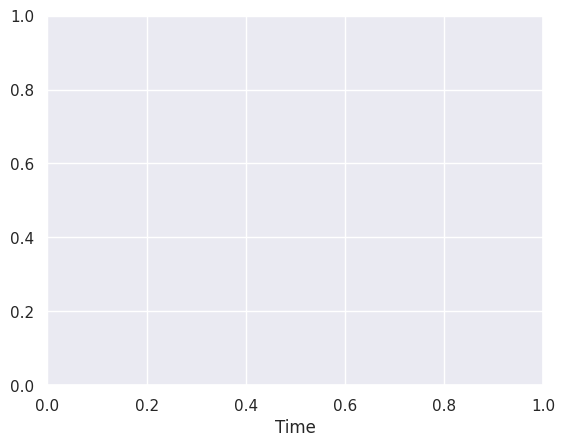

In [ ]:
import matplotlib as mpl
mpl.use('Agg')
#mpl.rc('font', **font)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as md
import datetime
import numpy as np
from pytz import timezone
import pandas as pd
import arrow
import os
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# Limits for graphs
VOLTAGE_LIM = 0.2
CURRENT_LIM = 40
POWER_LIM = 4

line_width = 0.5
plt.title("1 hour prediction interval")

plt.close()
plt.xlabel("Time")
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(4,3), sharex=False)
fig.autofmt_xdate()

volt_color= 'tab:blue'

amp_color = 'tab:red'


volt_color1= 'tab:blue'
volt_style1 = 'dashed'
volt_color2= 'tab:green'
volt_style2 = 'dashed'
volt_color3= 'tab:red'
volt_style3 = 'dashed'
volt_color4= 'tab:orange'
volt_style4 = 'dashed'

#amp_color1 = 'tab:red'
#amp_style1='dashed'
#amp_color2 = 'tab:orange'
#amp_style2='dashdot'

ax1.fmt_xdata = md.DateFormatter('%m-%d')
ax1.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))
ax1.grid(True)

ax2.fmt_xdata = md.DateFormatter('%m-%d')
ax2.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))
ax2.grid(True)

ax3.fmt_xdata = md.DateFormatter('%m-%d')
ax3.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))
ax3.grid(True)

ax1.set_ylabel("Power (μW)", fontsize=7.5, labelpad = 2.5)
ax2.set_ylabel("Voltage (mV)", fontsize=7.5, labelpad = 2.5)
ax3.set_ylabel("Current (μA)", fontsize=7.5, labelpad = 2.5)
#ax3.set_xlabel("Date", fontsize=10)

ax1.set_ylim(0, 1.5)
ax2.set_ylim(0, 60)
ax3.set_ylim(0, 40)

#ax3.set_xlim([datetime.date(2021, 12, 12), datetime.date(2021, 12, 14)])
ax1.set_xlim([mv1.index[0], mv1.index[-1]])
ax2.set_xlim([mv1.index[0], mv1.index[-1]])
ax3.set_xlim([mv1.index[0], mv1.index[-1]])

ax1.plot(mv1.index, mv2["power_pred_lower"] * 1E-3, color='tab:red', ls = volt_style3, linewidth=line_width)
ax1.plot(mv1.index, mv2["power_pred_upper"] * 1E-3, color='tab:orange', ls = volt_style4, linewidth=line_width)
ax1.plot(mv1.index, mv2["power"] * 1E-3, color='tab:blue', ls = 'solid', linewidth=line_width)
ax1.plot(mv1.index, mv2["power_pred_med"] * 1E-3, color='tab:green', ls = volt_style2, linewidth=line_width)
ax1.fill_between(mv1.index, mv2["power_pred_lower"] * 1E-3, mv2["power_pred_upper"] * 1E-3, color='grey', alpha=0.5)
#ax1.legend(['lower bound', 'upper bound', 'actual', 'median predictions'], loc='lower center', prop={'size': 5.5}, ncol=2)

ax2.plot(mv1.index, mv2["voltage_pred_lower"] * 1E-2, color='tab:red', ls = volt_style3, linewidth=line_width)
ax2.plot(mv1.index, mv2["voltage_pred_upper"] * 1E-2, color='tab:orange', ls = volt_style4, linewidth=line_width)
ax2.plot(mv1.index, mv2['V1 [mV]'] * 1E-2, color='tab:blue', ls = 'solid', linewidth=line_width)
ax2.plot(mv1.index, mv2["voltage_pred_med"] * 1E-2, color='tab:green', ls = volt_style2, linewidth=line_width)
ax2.fill_between(mv1.index, mv2["voltage_pred_lower"] * 1E-2, mv2["voltage_pred_upper"] * 1E-2, color='grey', alpha=0.5)
ax2.legend(['lower bound', 'upper bound', 'ground truth', 'median prediction'], loc='lower left', prop={'size': 6.6}, ncol=2, columnspacing=0.5)

ax3.plot(mv1.index, mv2["current_pred_lower"] * 1E-2, color='tab:red', ls = volt_style3, linewidth=line_width)
ax3.plot(mv1.index, mv2["current_pred_upper"] * 1E-2, color='tab:orange', ls = volt_style4, linewidth=line_width)
ax3.plot(mv1.index, mv2['I1L [μA]'] * 1E-2, color='tab:blue', ls = 'solid', linewidth=line_width)
ax3.plot(mv1.index, mv2["current_pred_med"] * 1E-2, color='tab:green', ls = volt_style2, linewidth=line_width)
ax3.fill_between(mv1.index, mv2["current_pred_lower"] * 1E-2, mv2["current_pred_upper"] * 1E-2, color='grey', alpha=0.5)
#ax3.legend(['lower bound', 'upper bound', 'actual', 'median predictions'], loc='upper right', prop={'size': 5.5}, ncol=1)


#Plot error
#ax3.plot(mv1['timestamp'], mv1['error']/mv1['power'], color=volt_color2, ls = volt_style2)
#ax3.legend(['error'], loc='upper right', prop={'size': 6})

ax3.tick_params(axis='x', labelsize=7.5, rotation=0, pad = 0.1)
ax3.set_xticks(list(ax3.get_xticks()) + [ax3.get_xlim()[0], ax3.get_xlim()[1]])
for label in ax3.get_xticklabels():
    label.set_horizontalalignment('center')

ax1.tick_params(axis='y', labelsize=7.5, rotation=0, pad = 0.1)
ax2.tick_params(axis='y', labelsize=7.5, rotation=0, pad = 0.1)
ax3.tick_params(axis='y', labelsize=7.5, rotation=0, pad = 0.1)

plt.tight_layout(pad=0.3, w_pad=0.5, h_pad=0.1)
#plt.subplots_adjust(hspace=0.15)
plt.savefig('twobat.pdf')
plt.close()